In [ ]:
import os
import numpy as np
from tqdm import tqdm

import torch
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from models.resnet_cifar import *
from models.vgg_cifar import *

from utils import add_hooks, remove_hooks, get_ZCA_matrix, ConeTransform
from mmd_function import MMD

# TODO: 
# - use batch MMD (or somehow I need to do the channel version without memory issues)
# - instead of GAP, get 4 dimensional vectors (where C = 4) like this Nx4xHxW  ---> (N*H*W)x4

# Variables
mode = "iid" # non_iid, iid
extract_mode = "gap" # flatten, channel, gap
network_name = "vgg11" # resnet20, vgg11, vgg11conv0, resnet20conv0
num_classes = 10
resolution = 32
MMD_path = './MMD_values'

ZCA_preprocessing = True
ZCA_conv0 = False
lmscone = True

if ZCA_conv0:
    assert 'conv0' in network_name, 'ZCA_conv0 is True but network_name does not contain conv0'
    zca_conv0_path = './../ZCA_init_cifar10/outputs/conv0_ZCAinit_cifar10res32_addgray/'
    if lmscone:
        zca_conv0_path = './../ZCA_init_cifar10/outputs/conv0_ZCAinit_cifar10res32_addgray_lmscone/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MMD_path = os.path.join(MMD_path, f'{network_name}_cifar10res{resolution}')
if not os.path.exists(MMD_path):
    os.makedirs(MMD_path)

# Seed everything
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Load transform for CIFAR10
if lmscone: # use values calculated for these transformation (cifar10 values)
    mean = [0.61700356, 0.6104542, 0.5773882]
    std = [0.23713203, 0.2416522, 0.25481918]
else: # RGB cifar10 values
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.247, 0.243, 0.261]

if ZCA_conv0:
    std = [1.0, 1.0, 1.0]

if lmscone:
    transform = T.Compose([
        T.Resize(resolution),
        T.ToTensor(),
        ConeTransform(),
        T.Normalize(mean=mean,
                    std=std),
    ])
else:
    transform = T.Compose([
        T.Resize(resolution),
        T.ToTensor(),
        T.Normalize(mean=mean,
                    std=std),
    ])
# Load CIFAR10 dataset test set
dataset = CIFAR10(root='/data/datasets/CIFAR10', train=False, download=False, transform=transform)

if ZCA_preprocessing:
    # Calculate zca matrix using train set
    traindataset = CIFAR10(root='/data/datasets/CIFAR10', train=True, download=False, transform=transform)
    ZCA_obj = get_ZCA_matrix(traindataset, num_imgs=len(traindataset))

# Load indices
indices_path = './indices'
if mode == "iid":
    indices_A = np.load(f'{indices_path}/IID_indices_A_test.npy')
    indices_B = np.load(f'{indices_path}/IID_indices_B_test.npy')
elif mode == "non_iid":
    indices_A = np.load(f'{indices_path}/Non_IID_indices_A_test.npy')
    indices_B = np.load(f'{indices_path}/Non_IID_indices_B_test.npy')

# Get datasets A and B with subset and create loaders
data_A = torch.utils.data.Subset(dataset, indices_A)
data_B = torch.utils.data.Subset(dataset, indices_B)
loader_A = torch.utils.data.DataLoader(data_A, batch_size=256, shuffle=False)
loader_B = torch.utils.data.DataLoader(data_B, batch_size=256, shuffle=False)

# Load network and put it in eval mode
model = eval(network_name)(num_classes=num_classes)
if ZCA_conv0:
    zca_conv0_weight = torch.load(os.path.join(zca_conv0_path,'F_ZCA_weights.pth'))
    zca_conv0_bias = torch.load(os.path.join(zca_conv0_path,'F_ZCA_bias.pth'))
    model.conv0.weight = torch.nn.Parameter(zca_conv0_weight)
    model.conv0.bias = torch.nn.Parameter(zca_conv0_bias)
model.to(device)
model.eval()

In [16]:
X, _ = next(iter(loader_A))
whitened_X = ZCA_obj.transform_data(X)

In [12]:
import matplotlib.pyplot as plt
def plotImage(img):
    plt.figure(figsize=(3,3))
    img = img.detach().cpu()
    img = (img - img.min()) / (img.max() - img.min())
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    elif len(img.shape) == 3:
        plt.imshow(img.permute(1,2,0))

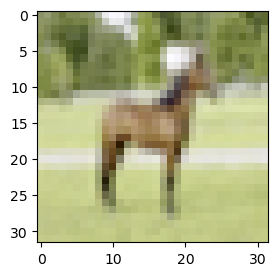

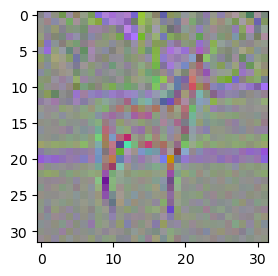

In [17]:
plotImage(X[2])
plotImage(whitened_X[2])

In [22]:
output = model.features[0](X.to(device))
output_whitened = model.features[0](whitened_X.to(device))

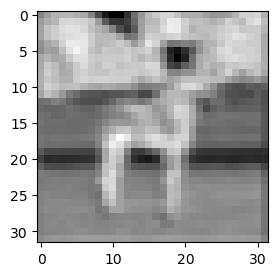

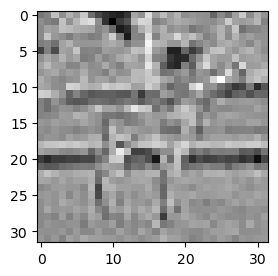

In [26]:
idx = 4
plotImage(output[2][idx])
plotImage(output_whitened[2][idx])